# Semi-Stochastic Gradient Descent Methods
**Implementation and experiments**

[Article](https://arxiv.org/pdf/1312.1666.pdf)

## Define Functions for Semi-Stochastic gradient Descent

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
from inspect import Parameter
from time import time

In [29]:
# Sample tj
def create_P(h,m, nu):
	"""
	Return P list of probability prop to (1 - nu*h)**(m-t)
	"""
	P = np.array([(1.-nu*h)**(m-t) for t in range(1,m+1)])
	P /= np.sum(P)
	P = np.cumsum(P)
	P[-1] = 1.
	return P


def rand_from(cum_p):
	"""
	Return t with probability prop to (1 - nu*h)**(m-t)
	"""
	u = np.random.random()
	return np.searchsorted(cum_p,u)

# L2_regularized_least_squares
def L2_regularized_least_squares_grad(x, a, b, lambd):
	"""Compute the grad of L2-regularized least squares"""
	return 2*a*(a.T@x-b) + lambd*x


def L2_regularized_least_squares(x, A, B, lambd):
	"""Compute L2-regularized least squares"""
	n = A.shape[0]
	return np.sum((np.dot(A, x) - B)**2)/n + np.sum(x**2)*lambd/2


# L2_regularized_logistic_loss
def L2_regularized_logistic_loss(x, A, y, lamb):
    """Compute L2-regularized logistic loss"""
    n = A.shape[0]
    f = 0
    for i in range(n):
        a_i = A[i]
        f += -(y[i]*np.log(1/(1+np.exp(-x.T@a_i))) +(1-y[i])*np.log(1-1/(1+np.exp(-x.T@a_i)))) + np.sum(x**2)*lamb/2
    return f/n


def L2_regularized_logistic_loss_grad(x, a, yi, lamb):
    return ((1-yi)*a.T - yi*np.exp(-x.T@a)*a.T)/(1+np.exp(-x.T@a)) + lamb*x


# Get best parameters to compute complexity 
def get_best_param(nu, mu, L, epsilon):
		"""Compute optimal parameters in order to minimize computationnal time"""
		j = math.ceil(np.log(1/epsilon))
		delta = epsilon**(1/j)
		k = L / mu
		h = 1 / (4*(L-mu)/delta + 4*L)
		if nu==0:
				m = math.ceil(8*(k-1)/(delta**2) + 8*k/delta + 2*(k**2)/(k-1))
		else:
				m = math.ceil((4*(k-1)/delta + 2*k) * np.log(2/delta + (2*k-1)/(k-1)))
		return j, h, m

In [30]:
def ssgd(A, B, x_init, x_star, f, f_grad, mu, L, epsilon=1e-6, nu=0, brut_parameters=None, alpha_for_plus = None):
    """Executes semi stochastic gradient descent algorithm on f

    Args:
        A, B : Arguments for computation of f
        x_init, x_star : starting point and optimal point
        f, f_grad : function to optimize and it's gradient
        mu, L : parameters of the problem
        epsilon : expected precision
        nu : lower bound for mu
        brut_parameters : if none, choose best parameters to minimize complexity, otherwhise use parameters given
    Returns:
        x : solution point 
        error_history : distance to the optimal point throug iterations
        number_of_iterations : list of number of iterations per epoch 
    """    
    n = A.shape[0]
    if brut_parameters is None:
        J, h, m = get_best_param(nu, mu, L, epsilon)
        print("\nChosen parameters : ")
        print("J =", J)
        print("h =", h)
        print("m =", m)
    else:
        J = math.ceil(np.log(1/epsilon))
        h, m = brut_parameters

    # Param to optim: x
    x = x_init.copy()

    P = create_P(h, m, nu)

    if x_star is None:
        error_history = [abs(f(x, A, B))]
    else:
        error_history = [abs(f(x, A, B) - f(x_star, A, B))]
        
    number_of_iterations = [0]
    x_list = [x_init]

    for j in range(J):
        g = np.mean(np.array([f_grad(x, A[i], B[i]) for i in range(n)]), axis=0)
        y = x.copy()

        # Pick random t
        if alpha_for_plus == None:
            tj = rand_from(P)
        else:
            print("Using SSGD+ version")
            tj = int(alpha_for_plus*n)

        for t in range(tj):
            i = np.random.randint(0, n)
            y = y - h * (g + f_grad(y, A[i], B[i]) - f_grad(x, A[i], B[i]))

        number_of_iterations.append(number_of_iterations[-1]+tj)
        if x_star is None:
            error_history.append(abs(f(y, A, B)))
        else:
            error_history.append(abs(f(y, A, B) - f(x_star, A, B)))
                
        
        x = y.copy()
        x_list.append(x)
    return x_list, error_history, number_of_iterations

In [31]:
def ssgd_plus(A, B, x_init, x_star, f, f_grad, mu, L, alpha=1, epsilon=1e-6, nu=0, brut_parameters=None):
    n = A.shape[0]

    if brut_parameters is None:
        J, h, m = get_best_param(nu, mu, L, epsilon)
        print("\nChosen parameters : ")
        print("J =", J)
        print("h =", h)
        print("m =", m)
        brut_parameters = h, m
    else:
        J = math.ceil(np.log(1/epsilon))
        h, m = brut_parameters

    x, errors_sgd, n_it_sgd= stochastic_gradient_descent(A, B,x_init, x_star, f, f_grad, h, N_iter = n )
    x_ssgd, errors_ssgd, n_it_ssgd = ssgd(A, B, x, x_star, f, f_grad, mu, L, epsilon=epsilon, nu = nu, brut_parameters=brut_parameters)
    n_it = n_it_sgd+ [it+max(n_it_sgd) for it in n_it_ssgd]
    return x + x_ssgd, errors_sgd+errors_ssgd, n_it
    #return np.concatenate(x, x_ssgd), np.concatenate(errors_sgd, errors_ssgd), np.concatenate([n],n_it_ssgd)

In [32]:
def gradient_descent(A, B, x_init, x_star, f, f_grad, h, N_iter = 100000):
    """Executes gradient descent algorithm on f

    Args:
        A, B : Arguments for computation of f
        x_init, x_star : starting point and optimal point
        f, f_grad : function to optimize and its gradient
        N_iter: nb of iterations to run 
        h: step size
    Returns:
        x : solution point 
        error_history : distance to the optimal point throug iterations
        number_of_iterations : list of number of iterations per epoch 
    """    
    n = A.shape[0]
    x = x_init.copy()
    error_history = [abs(f(x, A, B) - f(x_star, A, B))]
    number_of_iterations = [0]
    verbose = int(N_iter/100)

    for i in range(N_iter):
        x -= h*np.mean(np.array( [f_grad(x, A[l], B[l]) for  l in range(n)] ), axis = 0)

        if not i% verbose:
              error_history.append(abs(f(x, A, B) - f(x_star, A, B)))        
              number_of_iterations.append(i+1)

    return x, error_history, number_of_iterations
    

In [33]:
def stochastic_gradient_descent(A, B, x_init, x_star, f, f_grad, h, N_iter = 100000):
    """Executes gradient descent algorithm on f

    Args:
        A, B : Arguments for computation of f
        x_init, x_star : starting point and optimal point
        f, f_grad : function to optimize and its gradient
        N_iter: nb of iterations to run 
        h: step size
    Returns:
        x : solution point 
        error_history : distance to the optimal point throug iterations
        number_of_iterations : list of number of iterations per epoch 
    """    
    n = A.shape[0]
    x = x_init.copy()
    number_of_iteration = [0]
    error_history = [abs(f(x, A, B) - f(x_star, A, B))]
    verbose = int(N_iter/100)
    for i in range(N_iter):
        l = np.random.randint(0, n)
        x -= h*f_grad(x, A[l], B[l])
        if not i% verbose:
            error_history.append(abs(f(x, A, B) - f(x_star, A, B)))        
            number_of_iteration.append(i+1)

    return x, error_history, number_of_iteration

## L2-regularized least squares

Nous utilisons les formules de 5. pour choisir nos paramètres, et comparons avec les performances en utilisant les paramètres proposés dans le papier. 

### SSGD

Partie 7.2 du papier de recherche.

In [ ]:
# Data
d = 10
n = 1000
x_star = np.random.rand(d)
x_init = np.ones(d)/d
A = np.random.rand(n,d)
B = np.dot(A, x_star)

In [ ]:
# Define the problem
## here nu = lambda, choose parameters to minimize complexity
lamb = 0.5
nu = lamb
f = lambda x, a, b: L2_regularized_least_squares(x, a, b, lamb)
f_grad = lambda x, a, b: L2_regularized_least_squares_grad(x, a, b, lamb)
L = 10000 * lamb
print("\nExpected parameters:")

if nu==0:
  print("h =", 1/(12.7*L))
  print("m = 426 660")
  params = (1/(12.7*L), 426660)
elif (nu - lamb) < 10e-6:
  print("h =", 1/(11.4*L))
  print("m = 261 063")
  params = (1/(11.4*L), 261063)

# Compute ssgd
x, hist, n_it = ssgd(A, B, x_init, x_star, f, f_grad, lamb, L, nu=nu)




Expected parameters:
h = 1.7543859649122806e-05
m = 261 063

Chosen parameters : 
J = 14
h = 1.3577999743658966e-05
m = 254188


In [ ]:
# Define the problem bis
# Here nu = 0, choose parameters  to minimize complexity
lamb = 0.05
nu = 0
f = lambda x, a, b: L2_regularized_least_squares(x, a, b, lamb)
f_grad = lambda x, a, b: L2_regularized_least_squares_grad(x, a, b, lamb)
L = 10000 * lamb
print("\nExpected parameters:")
if nu==0:
  print("h =", 1/(12.7*L))
  print("m = 426 660")
  params = (1/(12.7*L), 426660)
elif nu==lamb:
  print("h =", 1/(11.4*L))
  print("m = 261 063")
  params = (1/(11.4*L), 261063)

# Compute ssgd
x_2, hist_2, n_it_2 = ssgd(A, B, x_init, x_star, f, f_grad, lamb, L)


Expected parameters:
h = 0.00015748031496062991
m = 426 660

Chosen parameters : 
J = 14
h = 0.00013577999743658966
m = 810309


In [ ]:
## We wanted to compare with parameters in the paper, no difference noted

# # Define the problem 3
# # Here nu = mu, use paper's parameters
# lamb = 0.05
# nu = lamb
# f = lambda x, a, b: L2_regularized_least_squares(x, a, b, lamb)
# f_grad = lambda x, a, b: L2_regularized_least_squares_grad(x, a, b, lamb)
# L = 10000 * lamb
# print("\nExpected parameters:")
# if nu==0:
#   print("h =", 1/(12.7*L))
#   print("m = 426 660")
#   params = (1/(12.7*L), 426660)
# elif nu==lamb:
#   print("h =", 1/(11.4*L))
#   print("m = 261 063")
#   params = (1/(11.4*L), 261063)

# # Compute ssgd
# x_3, hist_3, n_it_3 = ssgd(A, B, x_init, x_star, f, f_grad, lamb, L, nu=nu, brut_parameters=params)

# # Define the problem 4
# # Here nu = 0, use paper's parameters
# lamb = 0.05
# nu = 0
# f = lambda x, a, b: L2_regularized_least_squares(x, a, b, lamb)
# f_grad = lambda x, a, b: L2_regularized_least_squares_grad(x, a, b, lamb)
# L = 10000 * lamb
# print("\nExpected parameters:")
# if nu==0:
#   print("h =", 1/(12.7*L))
#   print("m = 426 660")
#   params = (1/(12.7*L), 426660)
# elif nu==lamb:
#   print("h =", 1/(11.4*L))
#   print("m = 261 063")
#   params = (1/(11.4*L), 261063)

# # Compute ssgd
# x_4, hist_4, n_it_4 = ssgd(A, B, x_init, x_star, f, f_grad, lamb, L, nu=nu, brut_parameters=params)

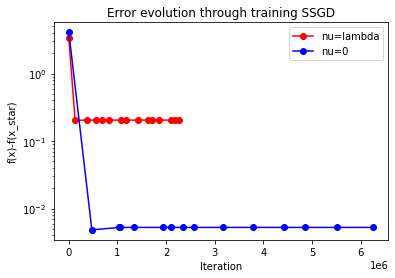

In [ ]:
# print evolution of the error

plt.plot(n_it, hist, 'ro-', label='nu=lambda')
plt.plot(n_it_2, hist_2, 'bo-', label='nu=0')

#plt.plot(n_it_3, hist_3, 'g--', label="nu=lambda, paper's parameters")
#plt.plot(n_it_4, hist_4, 'p--', label="nu=0, paper's parameters")
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('f(x)-f(x_star)')
plt.legend()
plt.title('Error evolution through training SSGD')
plt.show()

### SSGD +


In [ ]:
# Data
d = 10
n = 1000
x_star = np.random.rand(d)
x_init = np.ones(d)/d
A = np.random.rand(n,d)
B = np.dot(A, x_star)

In [ ]:
# Define the problem
## here nu = lambda, choose parameters to minimize complexity
lamb = 0.05
nu = lamb
f = lambda x, a, b: L2_regularized_least_squares(x, a, b, lamb)
f_grad = lambda x, a, b: L2_regularized_least_squares_grad(x, a, b, lamb)
L = 10000 * lamb
print("\nExpected parameters:")

if nu==0:
  print("h =", 1/(12.7*L))
  print("m = 426 660")
  params = (1/(12.7*L), 426660)
elif (nu - lamb) < 10e-6:
  print("h =", 1/(11.4*L))
  print("m = 261 063")
  params = (1/(11.4*L), 261063)

# Compute ssgd
x, hist, n_it = ssgd_plus(A, B, x_init, x_star, f, f_grad, lamb, L, nu=nu)




Expected parameters:
h = 0.00017543859649122806
m = 261 063

Chosen parameters : 
J = 14
h = 0.00013577999743658966
m = 254188


In [ ]:
# Define the problem bis
# Here nu = 0, choose parameters  to minimize complexity
lamb = 0.05
nu = 0
f = lambda x, a, b: L2_regularized_least_squares(x, a, b, lamb)
f_grad = lambda x, a, b: L2_regularized_least_squares_grad(x, a, b, lamb)
L = 10000 * lamb
print("\nExpected parameters:")
if nu==0:
  print("h =", 1/(12.7*L))
  print("m = 426 660")
  params = (1/(12.7*L), 426660)
elif nu==lamb:
  print("h =", 1/(11.4*L))
  print("m = 261 063")
  params = (1/(11.4*L), 261063)

# Compute ssgd
x_2, hist_2, n_it_2 = ssgd_plus(A, B, x_init, x_star, f, f_grad, lamb, L)


Expected parameters:
h = 0.00015748031496062991
m = 426 660

Chosen parameters : 
J = 14
h = 0.00013577999743658966
m = 810309


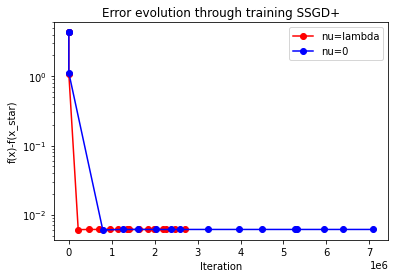

In [ ]:
# print evolution of the error
plt.plot(n_it, hist, 'ro-', label='nu=lambda')
plt.plot(n_it_2, hist_2, 'bo-', label='nu=0')

plt.xlabel('Iteration')
plt.ylabel('f(x)-f(x_star)')
plt.yscale('log')
plt.legend()
plt.title('Error evolution through training SSGD+')
plt.show()

### SSGD detailed

Pour mieux visualiser l'evolution de l'erreur au cours des itérations.
WARNING : very long computational time

In [ ]:
def ssgd_bis(A, B, x_init, x_star, f, f_grad, mu, L, epsilon=1e-3, nu=0, brut_parameters=None, alpha_for_plus = None):
    """Executes semi stochastic gradient descent algorithm on f + Compute error at each step

    Args:
        A, B : Arguments for computation of f
        x_init, x_star : starting point and optimal point
        f, f_grad : function to optimize and it's gradient
        mu, L : parameters of the problem
        epsilon : expected precision
        nu : lower bound for mu
        brut_parameters : if none, choose best parameters to minimize complexity, otherwhise use parameters given
    Returns:
        x : solution point 
        error_history : distance to the optimal point throug iterations
        number_of_iterations : list of number of iterations per epoch 
    """    
    n = A.shape[0]
    if brut_parameters is None:
        J, h, m = get_best_param(nu, mu, L, epsilon)
        print("\nChosen parameters : ")
        print("J =", J)
        print("h =", h)
        print("m =", m)
    else:
        J = math.ceil(np.log(1/epsilon))
        h, m = brut_parameters

    # Param to optim: x
    x = x_init.copy()

    P = create_P(h, m, nu)

    if x_star is None:
        error_history = [abs(f(x, A, B))]
    else:
        error_history = [abs(f(x, A, B) - f(x_star, A, B))]
        
    number_of_iterations = [0]
    x_list = [x_init]

    for j in range(J):
        g = np.mean(np.array([f_grad(x, A[i], B[i]) for i in range(n)]), axis=0)
        y = x.copy()

        # Pick random t
        if alpha_for_plus == None:
            tj = rand_from(P)
        else:
            print("Using SSGD+ version")
            tj = int(alpha_for_plus*n)

        for t in range(tj):
            i = np.random.randint(0, n)
            y = y - h * (g + f_grad(y, A[i], B[i]) - f_grad(x, A[i], B[i]))
            number_of_iterations.append(number_of_iterations[-1]+1)
            if x_star is None:
                error_history.append(abs(f(y, A, B)))
            else:
                error_history.append(abs(f(y, A, B) - f(x_star, A, B)))
                
        x = y.copy()
        x_list.append(x)
    return x_list, error_history, number_of_iterations

In [ ]:
# Data
d = 10
n = 1000
x_star = np.random.rand(d)
x_init = np.ones(d)/d
A = np.random.rand(n,d)
B = np.dot(A, x_star)

In [ ]:
# Define the problem
## here nu = lambda, choose parameters to minimize complexity
lamb = 0.5
nu = lamb
f = lambda x, a, b: L2_regularized_least_squares(x, a, b, lamb)
f_grad = lambda x, a, b: L2_regularized_least_squares_grad(x, a, b, lamb)
L = 10000 * lamb
print("\nExpected parameters:")

if nu==0:
  print("h =", 1/(12.7*L))
  print("m = 426 660")
  params = (1/(12.7*L), 426660)
elif (nu - lamb) < 10e-6:
  print("h =", 1/(11.4*L))
  print("m = 261 063")
  params = (1/(11.4*L), 261063)

# Compute ssgd
x, hist, n_it = ssgd_bis(A, B, x_init, x_star, f, f_grad, lamb, L, nu=nu)




Expected parameters:
h = 1.7543859649122806e-05
m = 261 063

Chosen parameters : 
J = 7
h = 1.3577999743658966e-05
m = 254188


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  import sys


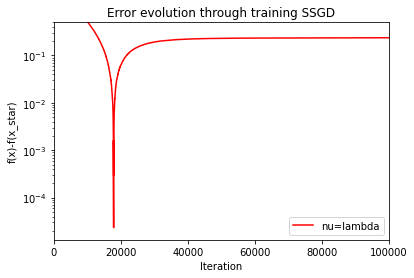

In [ ]:
# print evolution of the error

plt.plot(n_it, hist, color='r', label='nu=lambda')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('f(x)-f(x_star)')
plt.ylim(0,0.5)
plt.xlim(0,100000)
plt.legend()
plt.title('Error evolution through training SSGD')
plt.show()

## L2-regularized logistic loss on MNIST

Partie 7.3 du papier de recherche

In [34]:
import torchvision.datasets as dsets
import torch
import torchvision.transforms as transforms

train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False)

data_train = []
y_train = []
data_test = []
y_test = []

for image, label in train_loader:
    if label==5 or label==8:
       data_train.append((np.array(image)).flatten())
       if label==5:
          y_train.append(1)
       else:
          y_train.append(0)

for image, label in test_loader:
    if label==5 or label==8:
       data_test.append((np.array(image)).flatten())
       if label==5:
          y_test.append(1)
       else:
          y_test.append(0)

data_train = np.array(data_train)
data_test = np.array(data_test)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [35]:
# Define parameters
d = data_train.shape[1]
x_init = np.ones(d)/d
A = np.array(data_train)
y = np.array(y_train)

# Define the problem
## here nu = lambda
lamb = 0.05
nu = lamb
f = lambda x, a, y,: L2_regularized_logistic_loss(x, a, y, lamb)
f_grad = lambda x, a, y,: L2_regularized_logistic_loss_grad(x, a, y, lamb)
L = 320 * lamb
print("\nExpected parameters:")
if nu==0:
  print("h =", 1/(13.9*L))
  print("m = 17 062")
elif nu==lamb:
  print("h =", 1/(14.1*L))
  print("m = 11 686")
# Compute ssgd
x, hist, n_it = ssgd(A, y, x_init, None, f, f_grad, lamb, L, nu=nu,epsilon=1e-3)


Expected parameters:
h = 0.004432624113475178
m = 11 686

Chosen parameters : 
J = 7
h = 0.004252496364670794
m = 8115


In [36]:

## here nu =0
lamb = 0.05
nu = 0
L = 320 * lamb
print("\nExpected parameters:")
if nu==0:
  print("h =", 1/(13.9*L))
  print("m = 17 062")
elif nu==lamb:
  print("h =", 1/(14.1*L))
  print("m = 11 686")

# Compute ssgd
x_2, hist_2, n_it_2 = ssgd(A, y, x_init, None, f, f_grad, lamb, L, epsilon=1e-3)


Expected parameters:
h = 0.0044964028776978415
m = 17 062

Chosen parameters : 
J = 7
h = 0.004252496364670794
m = 25877


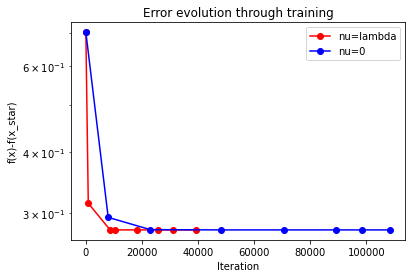

In [37]:
# print evolution of the error

plt.yscale('log')
plt.plot(n_it, hist,'ro-', label='nu=lambda')
plt.plot(n_it_2, hist_2, 'bo-', label='nu=0')
plt.xlabel('Iteration')
plt.ylabel('f(x)-f(x_star)')
plt.legend()
plt.title('Error evolution through training')
plt.show()

## Compare with Gradient Descent and Stochastic Gradient Descent

### Compare on Lin Reg

Let's compare SSGD, Stochastic Gradient Descent (SGD) and Gradient Descent (GD) performances on the linear regression model case. 

In [7]:
# Data
d = 10
n = 1000
x_star = np.random.rand(d)
x_init = np.ones(d)/d
A = np.random.rand(n,d)
B = np.dot(A, x_star)

In [8]:
# Define the problem
## here nu = lambda, choose parameters to minimize complexity
lamb = 0.05
f = lambda x, a, b: L2_regularized_least_squares(x, a, b, lamb)
f_grad = lambda x, a, b: L2_regularized_least_squares_grad(x, a, b, lamb)
L = 10000 * lamb



In [9]:
#Dictionary to save result of different experiments
results = {}

#Compute SSGD+
nu = lamb
t = time()
results['SSGD+; nu=mu'] = [ssgd_plus(A, B, x_init, x_star, f, f_grad, lamb, L, nu=nu)]
results['SSGD+; nu=mu'].append(time()-t)

#Compute SSGD+
nu = 0
t = time()
results['SSGD+; nu=0'] = [ssgd_plus(A, B, x_init, x_star, f, f_grad, lamb, L, nu=nu)]
results['SSGD+; nu=0'].append(time()-t)

#Compute SSGD
nu = lamb
t = time()
results['SSGD; nu=mu'] = [ssgd_plus(A, B, x_init, x_star, f, f_grad, lamb, L, nu=nu)]
results['SSGD; nu=mu'].append(time()-t)

#Compute SSGD
nu = 0
t = time()
results['SSGD; nu=0'] = [ssgd(A, B, x_init, x_star, f, f_grad, lamb, L, nu=nu)]
results['SSGD; nu=0'].append(time()-t)


# Compute sgd with h = 1/(3000*L)
t = time()
results["sgd; h=1/3000L"] = [stochastic_gradient_descent(A, B, x_init, x_star, f, f_grad, h = 1/(3000*L) , N_iter = 2000000)]
results['sgd; h=1/3000L'].append(time()-t)

# Compute sgd with h = 1/(300*L)
t = time()
results["sgd; h=1/300L"] = [stochastic_gradient_descent(A, B, x_init, x_star, f, f_grad, h = 1/(300*L) , N_iter = 2000000)]
results['sgd; h=1/300L'].append(time()-t)


Chosen parameters : 
J = 14
h = 0.00013577999743658966
m = 254188

Chosen parameters : 
J = 14
h = 0.00013577999743658966
m = 810309

Chosen parameters : 
J = 14
h = 0.00013577999743658966
m = 254188

Chosen parameters : 
J = 14
h = 0.00013577999743658966
m = 810309



Computationnal times :
SSGD+; nu=mu 60.86109638214111
SSGD+; nu=0 108.10424613952637
SSGD; nu=mu 52.46205139160156
SSGD; nu=0 126.47916579246521
sgd; h=1/3000L 33.740150451660156
sgd; h=1/300L 34.772425174713135


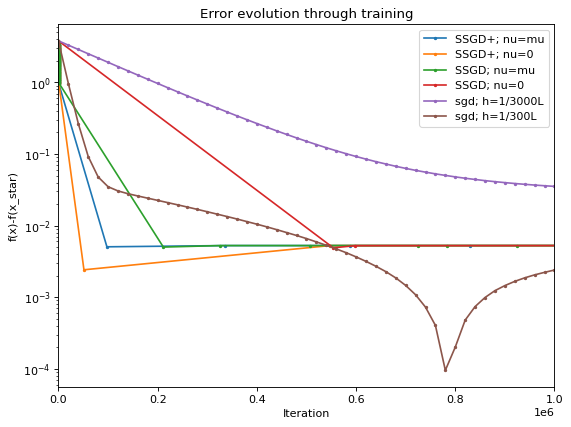

In [27]:
# print evolution of the error
plt.figure(figsize=(8, 6), dpi=80)
plt.yscale("log")
plt.xlim(0,(1e6))
print("\nComputationnal times :")
for k in results.keys():
	x, hist, n_it = results[k][0]
	t = results[k][1]
	print(k, t)
	plt.plot(n_it, hist, 'o-', label=k, markersize = 2)
plt.xlabel('Iteration')
plt.yscale('log')
plt.ylabel('f(x)-f(x_star)')
plt.legend(loc = 'upper right')
plt.title('Error evolution through training')
plt.show()